In [1]:
import os
import matplotlib.pyplot as plt
import random
from PIL import Image

In [2]:
dataset_path="RGB_224X224"

In [3]:
print(os.getcwd())

c:\Users\harsh\OneDrive\Desktop\image\RGB_224x224


In [4]:
train_dir = r"C:\Users\harsh\OneDrive\Desktop\image\RGB_224x224\train"

In [5]:
val_dir = r"C:\Users\harsh\OneDrive\Desktop\image\RGB_224x224\val"

In [6]:
test_dir = r"C:\Users\harsh\OneDrive\Desktop\image\RGB_224x224\test"

In [7]:
classes=os.listdir(train_dir)

In [8]:
len(classes)

139

In [9]:
random.sample(classes,5)

['Rye plant',
 'Oats plant',
 'Lentils plant',
 'Strawberries plant',
 'Cabbages and other brassicas plant']

In [10]:
def show_sample_images(num_classes=4):
    fig, axes=plt.subplots(num_classes,5,figsize=(15,3*num_classes))
    for i, class_name in enumerate(random.sample(classes,num_classes)):
        class_path=os.path.join(train_dir,class_name)
        images=os.listdir(class_path)

        for j in range(5):
            img_path=os.path.join(class_path,images[j])
            img=Image.open(img_path)
            axes[i,j].imshow(img)
            axes[i,j].set_title(class_name)
            axes[i,j].axis("off")
    plt.tight_layout()

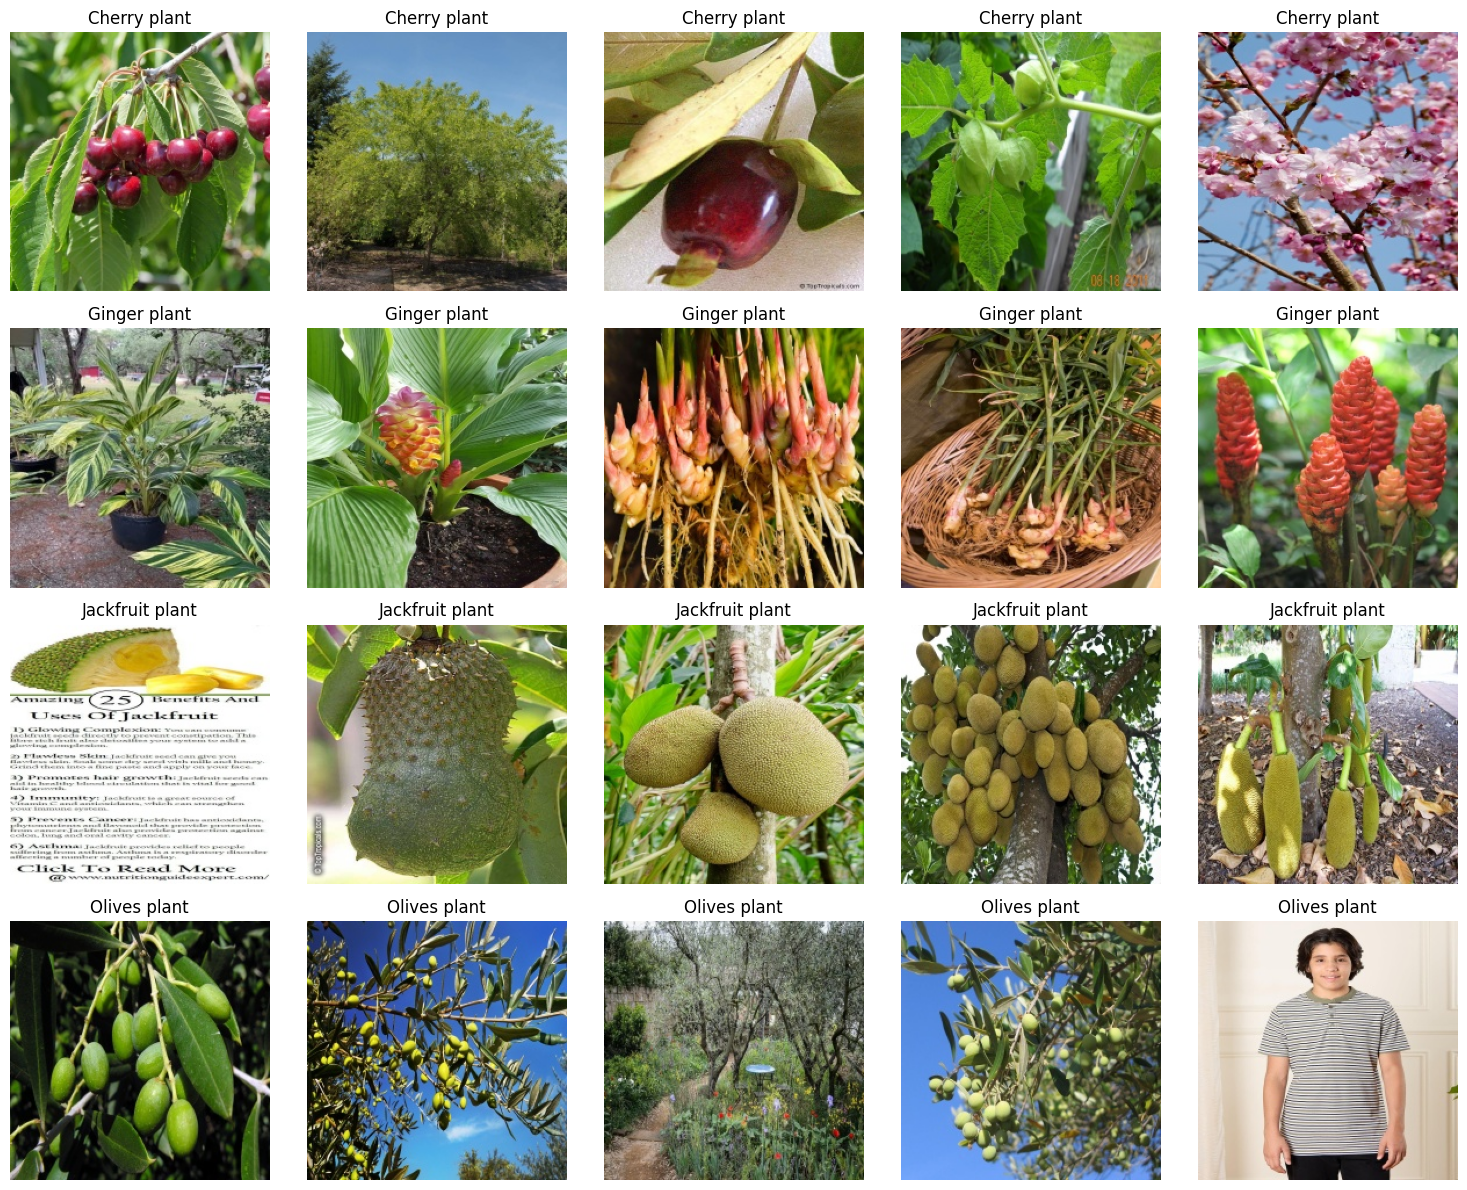

In [11]:
show_sample_images()

In [12]:
from sympy import im
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

In [13]:
transforms=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.2214,0.225])
])

In [14]:
train_dataset=ImageFolder(os.path.join(dataset_path,train_dir),transform=transforms)
val_dataset=ImageFolder(os.path.join(dataset_path,val_dir),transform=transforms)
test_dataset=ImageFolder(os.path.join(dataset_path,test_dir),transform=transforms)

In [15]:
train_loader=DataLoader(train_dataset,batch_size=128,shuffle=True,num_workers=8)
val_loader=DataLoader(val_dataset,batch_size=64,shuffle=False)
test_loader=DataLoader(test_dataset,batch_size=64,shuffle=False)

In [16]:
import torchvision.models as models
import torch.nn as nn

In [17]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [18]:
torch.backends.mps.is_available()

False

In [19]:
device=torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [20]:
device

device(type='cpu')

In [21]:
model=models.resnet18(pretrained=True)

c:\Users\harsh\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\harsh\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [22]:
for param in model.parameters():
    param.requires_grad=False

In [23]:
from ast import mod


num_classes=len(train_dataset.classes)
model.fc=nn.Linear(model.fc.in_features,num_classes)
model=model.to(device)

In [24]:
import torch.optim as optim
import torch.nn.functional as F

In [25]:
optimizer=optim.Adam(model.parameters(),lr=0.001)
criterion=nn.CrossEntropyLoss()

In [26]:
def train_one_epoch(model,loader):
    model.train()
    running_loss=0

    for images,labels in loader:
        images, labels=images.to(device),labels.to(device)
        optimizer.zero_grad()
        outputs=model(images)
        loss=criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        running_loss+=loss.item()

    return running_loss/len(loader)

In [27]:
from streamlit import image


def evaluate(model, loader):
    model.eval()
    correct=0
    total=0

    with torch.no_grad():
        for images,labels in loader:
            images,labels=images.to(device),labels.to(device)
            outputs=model(images)
            _,predicted=torch.max(outputs.data,1)
            total+=labels.size(0)
            correct+=(predicted==labels).sum().item()
    return correct/total

In [28]:
epochs=5

for epoch in range(epochs):
    train_loss=train_one_epoch(model,train_loader)
    val_acc=evaluate(model,val_loader)
    print(f"Epoch {epoch+1},Train Loss: {train_loss:.4f},Val Accuracy:{val_acc:.4f}")

KeyboardInterrupt: 

In [ ]:
test_acc=evaluate(model,test_loader)

In [ ]:
print(f"Test Accuracy:{test_acc:.4f}")

Test Accuracy:0.4610


In [ ]:
def visualize_predictions(model,loader,n=5):
    model.eval()
    images_shown=0
    class_names=train_dataset.classes

    with torch.no_grad():
        for images, labels in loader:
            images=images.to(device)
            outputs=model(images)
            _,preds=torch.max(outputs,1)

            for i in range(n):
                img=images[i].cpu().permute(1,2,0).numpy()
                plt.imshow((img*0.229+0.485))
                plt.title(f"True:{class_names[labels[i]]},Pred:{class_names[preds[i]]}")
                plt.axis("off")
                plt.show()

                images_shown+=1

                if images_shown>=n:
                    return


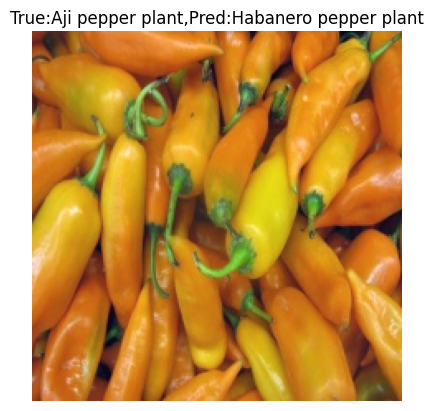

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.02352938..1.047674].


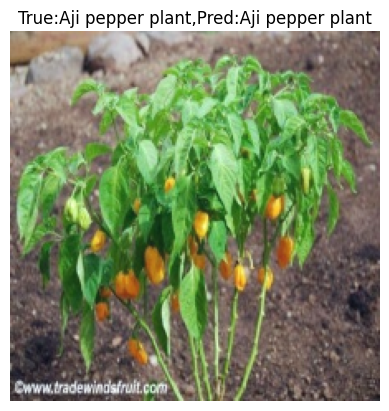

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.007843137..1.08956].


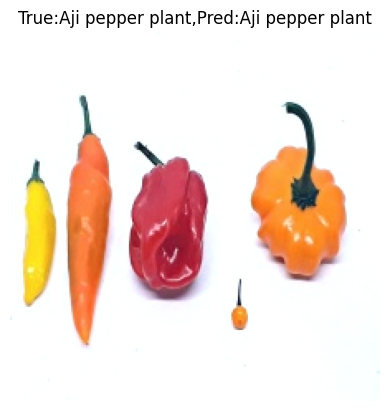

In [ ]:
visualize_predictions(model,test_loader,3)

In [ ]:
import joblib

In [ ]:
model_data={
    "model_state_dict":model.state_dict(),
    "class_to_idx":train_dataset.class_to_idx
}

In [ ]:
model_data

{'model_state_dict': OrderedDict([('conv1.weight',
               tensor([[[[-1.0419e-02, -6.1356e-03, -1.8098e-03,  ...,  5.6615e-02,
                           1.7083e-02, -1.2694e-02],
                         [ 1.1083e-02,  9.5276e-03, -1.0993e-01,  ..., -2.7124e-01,
                          -1.2907e-01,  3.7424e-03],
                         [-6.9434e-03,  5.9089e-02,  2.9548e-01,  ...,  5.1972e-01,
                           2.5632e-01,  6.3573e-02],
                         ...,
                         [-2.7535e-02,  1.6045e-02,  7.2595e-02,  ..., -3.3285e-01,
                          -4.2058e-01, -2.5781e-01],
                         [ 3.0613e-02,  4.0960e-02,  6.2850e-02,  ...,  4.1384e-01,
                           3.9359e-01,  1.6606e-01],
                         [-1.3736e-02, -3.6746e-03, -2.4084e-02,  ..., -1.5070e-01,
                          -8.2230e-02, -5.7828e-03]],
               
                        [[-1.1397e-02, -2.6619e-02, -3.4641e-02,  ...,  3.2521e-

In [ ]:
joblib.dump(model_data,"crop_classifier_model.pkl")

['crop_classifier_model.pkl']